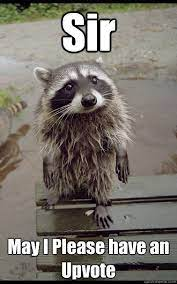

# PLEASE CHECKOUT MY NEW DATASET
- https://www.kaggle.com/keagle/mountains-dataset-with-coordinates-and-countries
- https://www.kaggle.com/keagle/list-of-indian-festivals-for-2022

Based on previous works
# Petfinder.my - Pawpularity Contest: Simple EDA and fastai starter

## A look at the data
Let's start out by setting up our environment by importing the required modules and setting a random seed:

In [ ]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model

In [ ]:
from fastai.vision.all import *

In [ ]:
set_seed(999, reproducible=True)
BATCH_SIZE = 64

Let's check what data is available to us:

In [ ]:
dataset_path = Path('../input/petfinder-pawpularity-score/')
dataset_path.ls()

We can see that we have our train csv file with the train image names, metadata and labels, the test csv file with test image names and metadata, the sample submission csv with the test image names, and the train and test image folders.

Let's check the train csv file:

In [ ]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

The metadata provided includes information about key visual quality and composition parameters of the photos. The Pawpularity Score is derived from the profile's page view statistics. This is the target we are aiming to predict.

Let's do some quick processing of the image filenames to make it easier to access:

In [ ]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

Okay, let's check how many images are available in the training dataset:

In [ ]:
len_df = len(train_df)
print(f"There are {len_df} images")

Let's check the distribution of the Pawpularity Score:

In [ ]:
train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")

In [ ]:
print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")

Note that the Pawpularity score is an integer, so in addition to being a regression problem, it could also be treated as a 100-class classification problem. Alternatively, it can be treated as a binary classification problem if the Pawpularity Score is normalized between 0 and 1:

In [ ]:
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']

Let's check an example image to see what it looks like:

In [ ]:
im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height)

In [ ]:
im

## Data loading
After my quick 'n dirty EDA, let's load the data into fastai as DataLoaders objects. We're using the normalized score as the label. I use some fairly basic augmentations here.

In [ ]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-large-transformer/swin_large_patch4_window12_384_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window12_384_22kto1k.pth'


In [ ]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [ ]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [ ]:
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
# num_bins

In [ ]:
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1


N_FOLDS = 5
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [ ]:
train_df[train_df['fold']==0].head()

In [ ]:
train_df[train_df['fold']==0]['bins'].value_counts()

In [ ]:
train_df[train_df['fold']==1]['bins'].value_counts()

In [ ]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [ ]:
def get_data_384(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
                               valid_col='is_valid', #
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               shuffle=False,
                               item_tfms=Resize(384), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    
    return dls

In [ ]:
def get_data_224(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
                               valid_col='is_valid', #
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               shuffle=False,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    
    return dls

In [ ]:
#Valid Kfolder size
the_data = get_data_384(0)
#assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

In [ ]:
def get_learner_384(fold_num):
    data = get_data_384(fold_num)
    
    model = create_model('swin_large_patch4_window12_384', pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse)
    
    return learn

In [ ]:
def get_learner_224(fold_num):
    data = get_data_224(fold_num)
    
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse)
    
    return learn

In [ ]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

In [ ]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

In [ ]:
#get_learner(fold_num=0).lr_find(end_lr=3e-2)

In [ ]:
import gc

In [ ]:
class eval_after_N_steps(Callback):
    
    def __init__(self,fold=None,n_step=None,start_epoch=0):
        self.counter = 0
        self.start_epoch = start_epoch
        self.n_step = n_step
        self.fold = fold
        self.best_rmse = 100000000
        
    def before_batch(self):
        self.counter = self.counter + 1
        if self.fold != None:
            if self.counter % self.n_step == 0 and int(self.counter/247) >= self.start_epoch :
                preds_list = []
                targ_list = []
                current_rmse_loss_list = []
                with torch.no_grad(): 
                    for xb,yb in learn.dls.valid:
                        preds = self.learn.model(xb)
                        current_rmse_loss_list.append(petfinder_rmse(preds,yb))
                    current_rmse_loss_array = np.array(current_rmse_loss_list,dtype='float')
                    current_rmse_loss = np.mean(current_rmse_loss_array)
                if current_rmse_loss < self.best_rmse:
                    self.best_rmse = current_rmse_loss
                    self.save(f'best_model_fold_{self.fold}')
                    print(f'best_rmse ----> {self.best_rmse}')


In [ ]:
def petfinder_diff(input,target):
    return torch.sum((100*((input.flatten()-target)))**2)

In [ ]:
len(os.listdir('../input/petfinder-pawpularity-score/test')) == 8

In [ ]:
all_preds = []
off_df = pd.DataFrame()
pred_test384, pred_test224 = [], []
import numpy as np
import joblib
# Both import methods supported
from cuml import Ridge
from cuml.linear_model import Ridge

for i in range(N_FOLDS):
    #swin 384
    print(f'Fold {i} results')
    if i == 2:
        learn = get_learner_384(fold_num=i)    
        state = torch.load(f'../input/transformer384-fold2/best_model_fold_2.pth')  
    else:
        learn = get_learner_384(fold_num=i)    
        state = torch.load(f'../input/transformer384-fold{i}/models/best_model_fold_{i}.pth')          
    learn.model.load_state_dict(state['model'])
    #learn = learn.to_fp32()
    
    #learn.export(f'model_fold_{i}.pkl')
    #learn.save(f'model_fold_{i}.pkl')
    
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               shuffle=False,
                               item_tfms=Resize(384), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 

    #val_preds, targs = learn.tta(n=10,beta=0.07)
    #print(f'rmse fold-{i}={rmse(100*val_preds,100*targs)}')
    #if len(os.listdir('../input/petfinder-pawpularity-score/test')) == 8:
    (preds_384_tta,preds_384), targs = learn.tta(n=4,beta=None)
    losses = petfinder_diff(preds_384,targs)
    losses = losses/preds_384.shape[0]
    losses = np.sqrt(losses)
    #print('without_svr_head:',losses)

    ###########  ensambling svr-head-preds with swin384-preds #############  
    activation = {}
    fold_activation = []
    targs = []
    
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    extra_valid_features = learn.dls.valid.items.iloc[:,:-6].values
    preds_valid = np.array([])
    with torch.no_grad(): 
         for n,(xb,yb) in enumerate(learn.dls.valid):
              learn.model.avgpool.register_forward_hook(get_activation('avgpool'))
              preds = learn.model(xb)
              preds_valid =  np.concatenate((preds_valid,preds.cpu().data.numpy().reshape(-1)),axis=0)
              if n == len(learn.dls.valid) - 1:
                 if xb.shape[0] == BATCH_SIZE:
                    targs.append(yb.cpu().data.numpy())
                    targs = np.array(targs)
                    targs = targs.reshape(-1)
                    fold_activation.append(activation['avgpool'].cpu().data.numpy())
                    fold_activation_array = np.array(fold_activation)
                    fold_activation_array = fold_activation_array.reshape(-1,fold_activation_array.shape[2])
                    
                 else:
                    targs = np.array(targs)
                    targs = targs.reshape(-1)
                    last_batch_targets = np.array(yb.cpu().data.numpy())
                    targs = np.concatenate((targs,last_batch_targets),axis=0)
                    fold_activation_array = np.array(fold_activation)
                    fold_activation_array = fold_activation_array.reshape(-1,fold_activation_array.shape[2])
                    last_batch_activations = activation['avgpool'].cpu().data.numpy().reshape(-1,fold_activation_array.shape[1])
                    fold_activation_array = np.concatenate((fold_activation_array,last_batch_activations),axis=0)
              else:
                  fold_activation.append(activation['avgpool'].cpu().data.numpy())
                  targs.append(yb.cpu().data.numpy())
                
    targs_array = np.array(targs)
    valid_targs = targs_array
    NN_preds = 1/(1 + np.exp(- preds_valid)) 

    svr_model =  joblib.load(f'../input/petfindder-swin-384-svr-training-with-extra-data/svr_head_model_swin384_fold{i}')
    X_valid = fold_activation_array 
    X_valid = np.concatenate((X_valid,extra_valid_features),axis=1)
    svr_preds = svr_model.predict(X_valid)
    svr_preds_head_swin_384 = svr_model.predict(X_valid)
    NN_preds_head_swin_384 = NN_preds    
    #alpha = np.array([0.01e-5])
    #ridge = Ridge(alpha = alpha,fit_intercept = True,normalize = False,solver = "eig")
    #X = np.concatenate((svr_preds.reshape(-1,1),NN_preds.reshape(-1,1),extra_valid_features),axis=1)    
    #ridge = joblib.load( f'../input/petfindder-swin-384-svr-training-with-extra-data/blender_model_for_svr_NN_swin384_fold{i}')
    #blender_svr_and_swin384_preds = ridge.predict(X)   
    #print(f"blending_svr_swin384_fold{i}_loss=",np.sqrt(np.mean((blender_svr_and_swin384_preds - valid_targs)**2)))
    
##########
    test_dl_384 = dls.test_dl(test_df)
    (_,preds_test_384), _ = learn.tta(dl=test_dl_384, n=1,beta=None)
    del learn ,svr_model 
    torch.cuda.empty_cache()
    gc.collect()
    
    #swin 224
    learn = get_learner_224(fold_num=i)    
    state = torch.load(f'../input/swintransformermodels/models/best_model_fold_{i}.pth')
    learn.model.load_state_dict(state['model'])
    learn.model.cuda()
    #learn = learn.to_fp32()
    #learn.export(f'model_fold_{i}.pkl')
    #learn.save(f'model_fold_{i}.pkl')
    
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    #val_preds, targs = learn.tta(n=10,beta=0.07)
    #print(f'rmse fold-{i}={rmse(100*val_preds,100*targs)}')
    #if len(os.listdir('../input/petfinder-pawpularity-score/test')) == 8:
    (preds_224_tta,preds_224), targs = learn.tta(n=5,beta=None)

    losses = petfinder_diff(preds_224,targs)
    losses = losses/preds_224.shape[0]
    losses = np.sqrt(losses)
    #print('without_svr_head ',losses)
    ################# ensambling svr-head preds and  swin-224 preds ##################   
    activation = {}
    fold_activation = []
    targs = []
    extra_valid_features = learn.dls.valid.items.iloc[:,:-6].values
    preds_valid = np.array([])
    with torch.no_grad(): 
         for n,(xb,yb) in enumerate(learn.dls.valid):
              learn.model.avgpool.register_forward_hook(get_activation('avgpool'))
              preds = learn.model(xb)
              preds_valid =  np.concatenate((preds_valid,preds.cpu().data.numpy().reshape(-1)),axis=0)
              if n == len(learn.dls.valid) - 1:
                 if xb.shape[0] == BATCH_SIZE:
                    targs.append(yb.cpu().data.numpy())
                    targs = np.array(targs)
                    targs = targs.reshape(-1)
                    fold_activation.append(activation['avgpool'].cpu().data.numpy())
                    fold_activation_array = np.array(fold_activation)
                    fold_activation_array = fold_activation_array.reshape(-1,fold_activation_array.shape[2])
                    
                 else:
                    targs = np.array(targs)
                    targs = targs.reshape(-1)
                    last_batch_targets = np.array(yb.cpu().data.numpy())
                    targs = np.concatenate((targs,last_batch_targets),axis=0)
                    fold_activation_array = np.array(fold_activation)
                    fold_activation_array = fold_activation_array.reshape(-1,fold_activation_array.shape[2])
                    last_batch_activations = activation['avgpool'].cpu().data.numpy().reshape(-1,fold_activation_array.shape[1])
                    fold_activation_array = np.concatenate((fold_activation_array,last_batch_activations),axis=0)
              else:
                  fold_activation.append(activation['avgpool'].cpu().data.numpy())
                  targs.append(yb.cpu().data.numpy())
                
    targs_array = np.array(targs)
    valid_targs = targs_array
    NN_preds = 1/(1 + np.exp(- preds_valid)) 

    svr_model =  joblib.load(f'../input/fork-of-swin-224-svr-training-meta-data/svr_head_model_swin224_fold{i}')
    X_valid = fold_activation_array 
    X_valid = np.concatenate((X_valid,extra_valid_features),axis=1)
    svr_preds_head_swin_224 = svr_model.predict(X_valid)
    NN_preds_head_swin_224 = NN_preds
    #alpha = np.array([0.01e-5])
    #ridge = Ridge(alpha = alpha,fit_intercept = True,normalize = False,solver = "eig")
    #X = np.concatenate((svr_preds.reshape(-1,1),NN_preds.reshape(-1,1),extra_valid_features),axis=1)    
    #ridge = joblib.load( f'../input/fork-of-swin-224-svr-training-meta-data/blender_model_for_svr_NN_swin224_fold{i}')
    #blender_svr_and_swin224_preds = ridge.predict(X)   
    #print(f"blending_svr_swin224_fold{i}_loss=",np.sqrt(np.mean((blender_svr_and_swin224_preds - valid_targs)**2)))
      

    test_dl_224 = dls.test_dl(test_df)
    (_,preds_test_224), _ = learn.tta(dl=test_dl_224, n=1,beta=None)
    del learn ,svr_model 
    torch.cuda.empty_cache()
    gc.collect()
    

    X = pd.DataFrame()
    X['swin_224_preds'] = np.array(preds_224).reshape(-1)
    X['svr_preds_head_swin_224'] = np.array(svr_preds_head_swin_224).reshape(-1)
    X['preds_224_tta'] = np.array(preds_224_tta).reshape(-1)
    X['swin_384_preds'] = np.array(preds_384).reshape(-1)
    X['svr_preds_head_swin_384'] = np.array(svr_preds_head_swin_384).reshape(-1)
    X['preds_384_tta'] = np.array(preds_384_tta).reshape(-1)

    meta_cols = ['Subject_Focus','Eyes','Face','Near','Action','Accessory','Group','Collage','Human','Occlusion','Info','Blur']
    X[meta_cols] = np.array(extra_valid_features)
   
    X['labels'] = valid_targs
    df_list = [off_df,X]
    off_df = pd.concat(df_list)

    X_test = pd.DataFrame()
    #X_test['swin_224_test_preds'] = np.array(preds_test_224).reshape(-1)
    #X_test['swin_384_test_preds'] = np.array(preds_test_384).reshape(-1)
    #joblib.dump(result_ridge, f'final_blender_model_fold{i}')
    #loaded_model = joblib.load('best_model_fold')
    #final_test_preds = result_ridge.predict(X_test)
    #all_preds.append(final_test_preds)
    del activation, fold_activation ,fold_activation_array ,targs_array ,X_valid
    gc.collect()


In [ ]:
alpha = np.array([0.01e-5])
ridge = Ridge(alpha = alpha,fit_intercept = True,normalize = False,solver = "eig")
result_ridge  = ridge.fit(off_df.iloc[:,:-1], off_df.iloc[:,-1])
final_preds = result_ridge.predict(off_df.iloc[:,:-1])
final_losses = petfinder_diff(torch.tensor(final_preds),torch.tensor(off_df.iloc[:,-1].values))
final_losses = final_losses/off_df.shape[0]
final_losses = np.sqrt(final_losses)
print(final_losses) 

In [ ]:
joblib.dump(result_ridge, f'final_blender_model')


In [ ]:
#np.mean(np.stack(all_preds*100))

In [ ]:
#sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
#preds = np.mean(np.stack(all_preds), axis=0)
#sample_df['Pawpularity'] = preds*100
#sample_df.to_csv('submission.csv',index=False)
#pd.read_csv('submission.csv').head()